In [28]:
import pandas as pd
import numpy as np
import networkx as nx
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("colorblind")
from matplotlib.gridspec import GridSpec
from adjustText import adjust_text
import pickle

In [ ]:
selected_brands = pd.read_csv('selected_brands.csv')['brands']
cbg_income = pd.read_csv('cbg_income.csv', dtype = {'cbg': str})
cbg_unpack = pd.read_csv('cbg_unpack.csv', dtype = {'visitor_home_cbgs': str})
yelp_labelled = pd.read_csv("yelp_labelled.csv")

# get poi_visitor_income 

- Every row has a unique pair of visitor_home_cbg and poi.
- Linked with cbg income for the home_cbg.
- only include selected brands

In [4]:
poi_visitor_income  = cbg_unpack[cbg_unpack['brands'].isin(selected_brands)]
poi_visitor_income  = pd.merge(poi_visitor_income, cbg_income, left_on = 'visitor_home_cbgs', right_on = 'cbg')
poi_visitor_income  = poi_visitor_income.drop(columns = ['visitor_home_cbgs'])
poi_visitor_income = poi_visitor_income.dropna(subset = ["income"])

In [5]:
poi_visitor_income

,placekey,brands,cbg_visitor_count,cbg,income
0,zzw-23k@627-s8r-dgk,CVS,4,120330011031,72375.0
1,zzw-223@627-wbv-k4v,Ripley's Entertainment Inc,4,120330011031,72375.0
2,zzw-23k@627-s8r-dgk,CVS,4,421010030012,51194.0
3,zzw-23k@627-s8r-dgk,CVS,4,360810717013,48750.0
4,222-222@627-s7t-sh5,Mobil,8,360810717013,48750.0
...,...,...,...,...,...
1201359,zzw-222@63q-kw3-yqf,Wendy's,4,391650307001,91109.0
1201360,224-222@627-s8n-52k,Fine Fare Supermarkets,4,240430004003,15000.0
1201361,zzy-223@629-n9r-r49,Eastern Mountain Sports,5,260290008001,63000.0
1201362,zzw-222@63q-5gb-jvz,Byrne Dairy,4,060710091071,77380.0


In [6]:
# get distribution of all visits
whole_array = (poi_visitor_income.loc[poi_visitor_income.index.repeat(poi_visitor_income['cbg_visitor_count'])])['income']

In [7]:
whole_array

0          72375.0
0          72375.0
0          72375.0
0          72375.0
1          72375.0
            ...   
1201362    77380.0
1201363    96908.0
1201363    96908.0
1201363    96908.0
1201363    96908.0
Name: income, Length: 5856774, dtype: float64

In [8]:
# shoing that 250001 is possibly a data collection thing
whole_array.value_counts()

250001.0    61044
86250.0      8775
78750.0      8387
96250.0      7293
68750.0      6959
            ...  
73798.0         4
110769.0        4
24519.0         4
73400.0         4
77380.0         4
Name: income, Length: 29737, dtype: int64

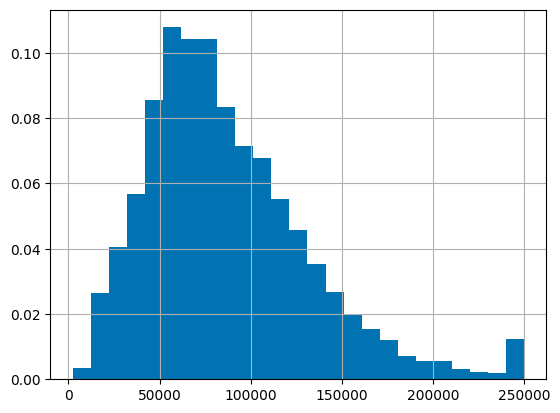

In [30]:
plt.figure()
whole_array.hist(weights = np.ones(len(whole_array)) / len(whole_array), bins = 25)
plt.show()

# for each brand get an array of visitors' home cbg median income


In [9]:
# poi_visitor_income = pd.read_csv("poi_visitor_income.csv")

In [10]:
def get_extended_array(brand_name):
    '''input brand name, outout an array of visitors' home cbg median income
    '''
    
    brand = poi_visitor_income[poi_visitor_income['brands'] == brand_name]
    brand = brand[['income', 'cbg_visitor_count']]
    brand = brand.loc[brand.index.repeat(brand['cbg_visitor_count'])]
    brand = brand.reset_index(drop = True)
    array = np.array(brand['income'])
    return array

In [ ]:
brand_array = pd.DataFrame({"brands": selected_brands})
array = brand_array.apply(lambda row: get_extended_array(row['brands']), axis = 1)
brand_array['array'] = array
brand_array = brand_array.set_index("brands")

In [37]:
# save raw data as pickle file
with open('brand_array.pkl', 'wb') as fw:
    pickle.dump(brand_array, fw)
fw.close()

In [ ]:
# open as pickle
with open('brand_array.pkl', 'rb') as fr:
    brand_array = pickle.load(fr)
fr.close()

# get median income of brand visitors

In [13]:
brand_median = brand_array.apply(lambda row: np.median(row['array']), axis = 1)

In [14]:
sum(brand_median == 0)

0

In [15]:
sum(whole_array == 0)

0

In [16]:
brand_median = pd.DataFrame(brand_median)
brand_median = brand_median.rename({0: 'median'}, axis = 1)

In [17]:
brand_median

,median
brands,
& Other Stories,88117.0
&pizza,107833.0
1-800-Flowers,118750.0
10 Spot/MadRag,49704.0
110 Grill,78178.0
...,...
lululemon athletica,106940.0
maurices,65357.0
rue21,63598.0


In [18]:
# brand_median.to_csv('brand_median.csv')

# plot brand ses vs yelp price level

In [19]:
sum(yelp_labelled['yelp_dollar'].isna())

148

In [20]:
sum(yelp_labelled['yelp_dollar'].notna())

776

In [21]:
price_ses = pd.merge(yelp_labelled, brand_median, on = 'brands')
price_ses = price_ses.dropna()

In [22]:
stats.pearsonr(price_ses['median'], price_ses['yelp_dollar'])

PearsonRResult(statistic=0.36284385458617163, pvalue=1.4719337477888988e-25)

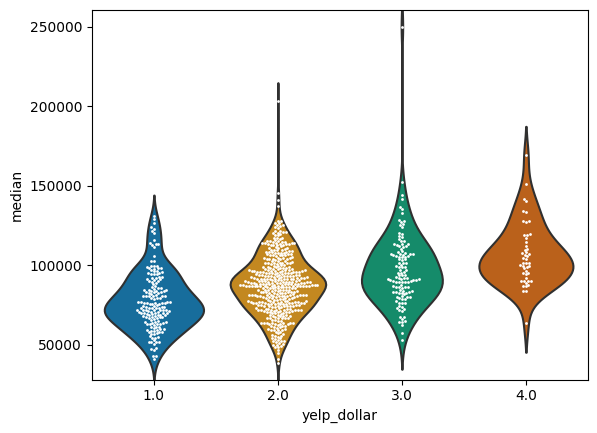

In [31]:
plt.figure()
ax = sns.violinplot(x="yelp_dollar", y="median", data=price_ses, inner=None)
ax = sns.swarmplot(x="yelp_dollar", y="median", data=price_ses,
                   color="white",  size=2, edgecolor="gray")

In [34]:
price_ses.sort_values('median')

,brands,yelp_dollar,median
330,Forman Mills,2.0,38535.0
421,Jimmy Jazz,2.0,40735.0
608,Peachwave Yogurt,1.0,40956.0
649,PriceRite,1.0,42647.0
324,Food Fair,1.0,42654.0
...,...,...,...
852,Valentino,4.0,151131.0
367,Green's Natural Foods,3.0,152344.0
494,Loro Piana,4.0,169092.5
482,Learning Express Toys,2.0,203438.0


In [35]:
poi_visitor_income[poi_visitor_income['brands'] == 'Balduccis']['placekey'].unique()

array(['222-222@627-scy-wzf', '22v-222@627-sbz-q4v'], dtype=object)

In [36]:
poi_visitor_income[poi_visitor_income['brands'] == 'Learning Express Toys']['placekey'].unique()

array(['zzw-22n@627-scb-dgk', '22j-222@627-sp5-qpv'], dtype=object)

In [37]:
# deleting two extreme outliers
price_ses2 = price_ses[~price_ses['brands'].isin(['Balduccis', 'Learning Express Toys'])]

In [38]:
stats.pearsonr(price_ses2['median'], price_ses2['yelp_dollar'])

PearsonRResult(statistic=0.3737301019300848, pvalue=4.591369461628846e-27)

In [39]:
callout = ['Lidl', 'Salsa Fresca Mexican Grill', 'Save-A-Lot', "Sears", "Green Cactus Grill", "Burger King",
           "Dollar Tree", "7-Eleven", "Taco Bell", "PriceRite", "Food Fair", "Forman Mills", "Victoria's Secret",
          "Zara", "Kmart", "Banana Republic", "Gap", "MAC Cosmetics", "Alexis Bittar", "Green's Natural Foods",
          "Kings Food Markets", "Whole Foods Market", "Johnson Fitness & Wellness", "UGG", "lululemon athletica",
          "Nike", "Timberland", "Camper", "Adidas", "Loro Piana", "Valentino", "Chanel", "Gucci",
          "Prada", "Canada Goose", "Tiffany & Co.", "Versace", "Fendi", "Peachwave Yogurt", "Marie Blachère", "Zales"]

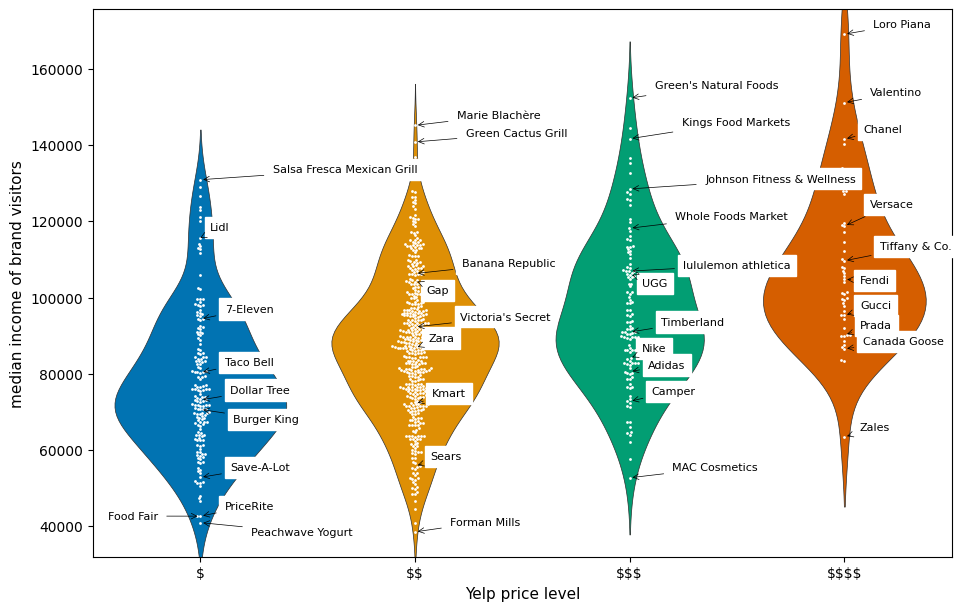

In [ ]:
fig, ax = plt.subplots(figsize=(9.5, 6), constrained_layout = True)
ax = sns.violinplot(x="yelp_dollar", y="median", data=price_ses2, inner=None, linewidth = 0.5,
                   saturation = 2)
ax = sns.swarmplot(x="yelp_dollar", y="median", data=price_ses2,
                   color="white",  size=2, edgecolor="gray")
ax.set_xlabel("Yelp price level", fontsize = 11)
ax.set_ylabel("median income of brand visitors", fontsize = 11)
ax.set_xticklabels(["\$", "\$\$", "\$\$\$", "\$\$\$\$"], fontsize = 10)
ax.yaxis.set_tick_params(labelsize = 10)

TEXTS = []
for i in range(len(price_ses2)):
    if price_ses2['brands'].iloc[i] in callout:
        x = price_ses2["yelp_dollar"].iloc[i] - 1
        y = price_ses2["median"].iloc[i]
        text = price_ses2['brands'].iloc[i]
        TEXTS.append(ax.text(x, y, text, fontsize = 8, backgroundcolor = 'white'))
        
adjust_text(
    TEXTS, 
    expand_points = (2, 2),
    expand_text = (2, 1.5),
    expand_objects = (2, 2),
    force_points = 0.2, 
    force_text = 0.2,
    force_objects = 0.2,
    arrowprops = dict(
        arrowstyle = "->",  
        linewidth = 0.5
    ),
    ax=fig.axes[0]
)

plt.show()
# plt.savefig('Figures/Figure2.png', dpi = 300)

In [43]:
# selecting brands to show
price_ses2[price_ses2['yelp_dollar'] == 2].sort_values('median')

,brands,yelp_dollar,median
330,Forman Mills,2.0,38535.0
421,Jimmy Jazz,2.0,40735.0
626,Pioneer Supermarkets,2.0,44563.0
363,Gordon Food Service Store,2.0,46667.0
449,Kids Foot Locker,2.0,48421.0
...,...,...,...
862,Versona,2.0,127813.0
905,Yogurtini,2.0,127955.0
47,Anthony's Coal Fired Pizza,2.0,136938.0
366,Green Cactus Grill,2.0,140833.0


# plot distribution of picked brands

In [44]:
# get distribution of all cbgs
all_cbg = poi_visitor_income[['cbg', 'income']].drop_duplicates().reset_index(drop = True)
all_cbg = all_cbg['income']

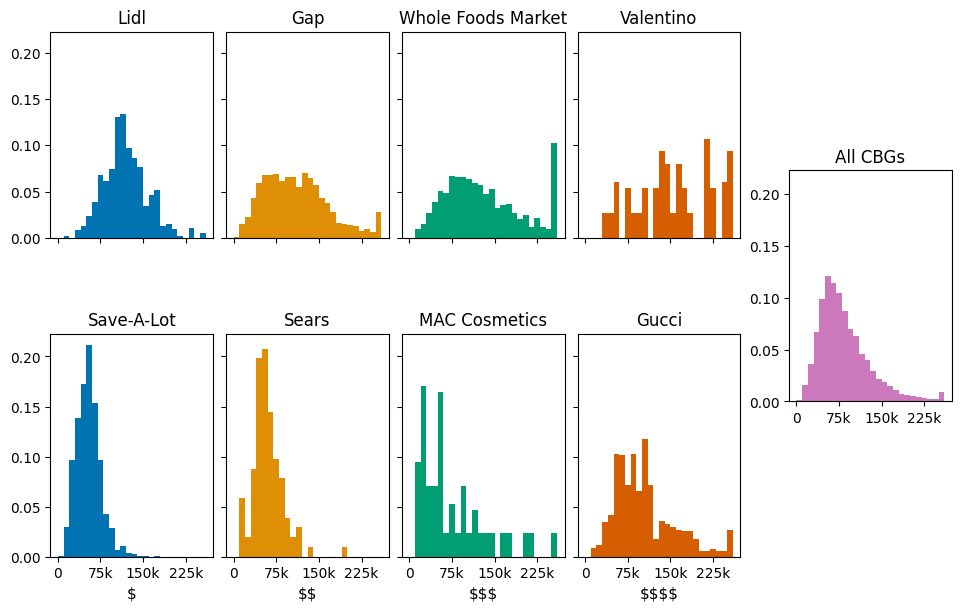

In [ ]:
# plot
pbrands = ["Lidl", "Gap", "Whole Foods Market", "Valentino",
           'Save-A-Lot', "Sears", "MAC Cosmetics", "Gucci"]

## create the gridspec
fig = plt.figure(figsize=(9.5, 6), constrained_layout = True)
gs = GridSpec(4, 5, figure = fig)
ax_lst = []
for i in range(9):
    if i < 4:
        if i == 0:
            ax_lst.append(fig.add_subplot(gs[:2, i]))
        else:
            ax_lst.append(fig.add_subplot(gs[:2, i], sharex=ax_lst[0], sharey=ax_lst[0]))
    elif i < 8:
        ax_lst.append(fig.add_subplot(gs[2:4, i - 4], sharex=ax_lst[0], sharey=ax_lst[0]))
    else:
        ax_lst.append(fig.add_subplot(gs[1:3, 4], sharex=ax_lst[0], sharey=ax_lst[0]))
        
## set the parameters to be filled 
binwidth = 10000
titles = ["Lidl", "Gap", "Whole Foods Market", "Valentino",
           'Save-A-Lot', "Sears", "MAC Cosmetics", "Gucci", 'All CBGs']
xlabels = [None]*4 + ["\$", "\$\$", "\$\$\$", "\$\$\$\$"] + [None]
bincolors = sns.color_palette("colorblind")[0:4] + sns.color_palette("colorblind")[0:4] + [sns.color_palette("colorblind")[4]]
labelbottoms = [False]*4 + [True]*5
labellefts = [True] + [False]*3 + [True] + [False]*3 + [True]

for i in range(len(ax_lst)):
    if i < 8:
        array = brand_array.loc[pbrands[i],'array']
    else:
        array = all_cbg
        
    ax_lst[i].hist(array, 
                   weights = np.ones(len(array)) / len(array),
                   bins=range(0, 260000 + binwidth, binwidth),
                   color = bincolors[i])
        
    ax_lst[i].set_title(titles[i], fontsize = 12) 
    ax_lst[i].set_xlabel(xlabels[i], fontsize = 11)
    ax_lst[i].xaxis.set_ticks(range(0, 300000, 75000))
    ax_lst[i].set_xticklabels(["0", "75k", "150k", "225k"])
    ax_lst[i].xaxis.set_tick_params(labelsize = 10)
    ax_lst[i].yaxis.set_tick_params(labelsize = 10)
    ax_lst[i].tick_params(labelbottom = labelbottoms[i], labelleft = labellefts[i])

plt.show()
# plt.savefig('Figures/Figure3.png', dpi = 300)